In [1]:
import os
import sys

import numpy as np
import cv2
from sklearn import linear_model

import lane_finding as lane

import lane_double_ransac as dlransac
from lane_double_ransac import DLanesRANSACRegressor

import lane_simple_ransac as slransac
from lane_simple_ransac import SLanesRANSACRegressor


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera calibration

Computation of the calibration parameters, and example proving we obtain the expected result.

Warning! Not chessboard found in image calibration1.jpg
Warning! Not chessboard found in image calibration5.jpg
Warning! Not chessboard found in image calibration4.jpg


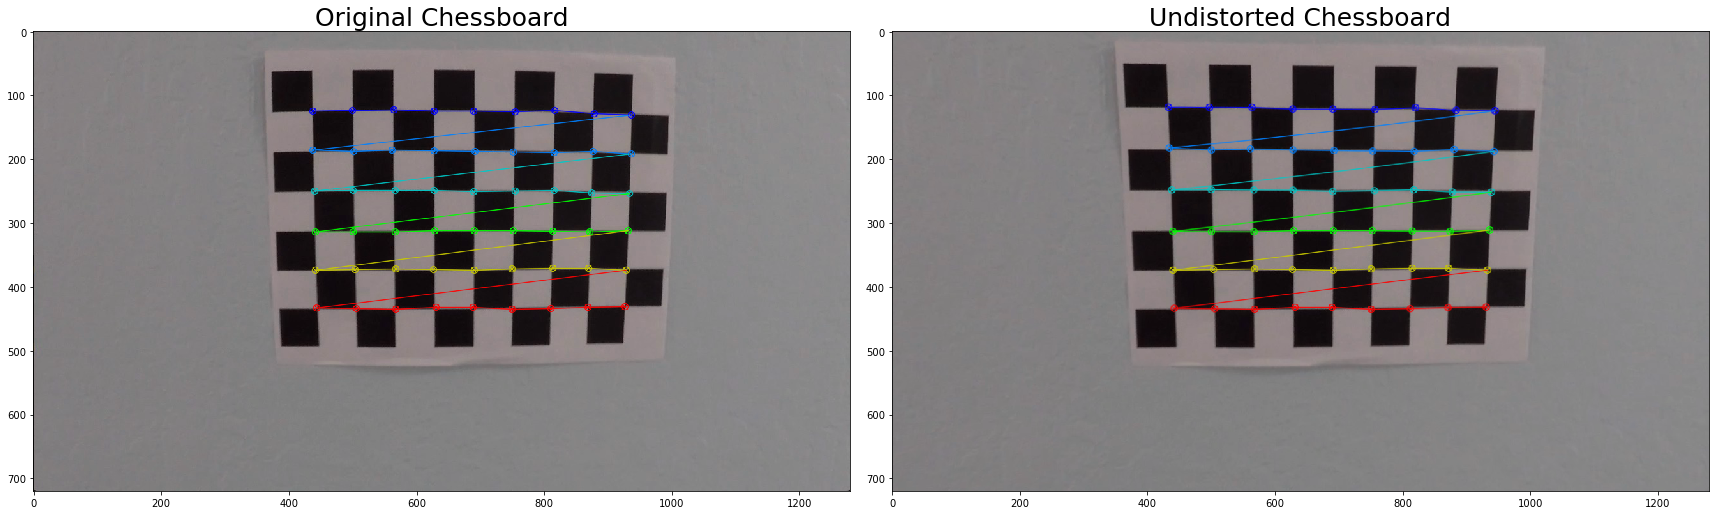

In [3]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = lane.calibration_parameters(path, cshape)

# Test calibration on some image.
filenames = os.listdir(path)
lane.test_calibration(path + filenames[11], cshape, mtx, dist)

## Perspective transform

Compute the perspective transform matrix using a sample image (in `perspective` directory). The source and destination points are stored in the json file `perspective.json`. Below is shown the result of the transform on the image used for determining the parameters.

Source points:
 [[  240.   720.]
 [  575.   460.]
 [  715.   460.]
 [ 1150.   720.]]
Destination points:
 [[ 440.  720.]
 [ 440.    0.]
 [ 950.    0.]
 [ 950.  720.]]
Perspective scaling: [ 0.042  0.006]


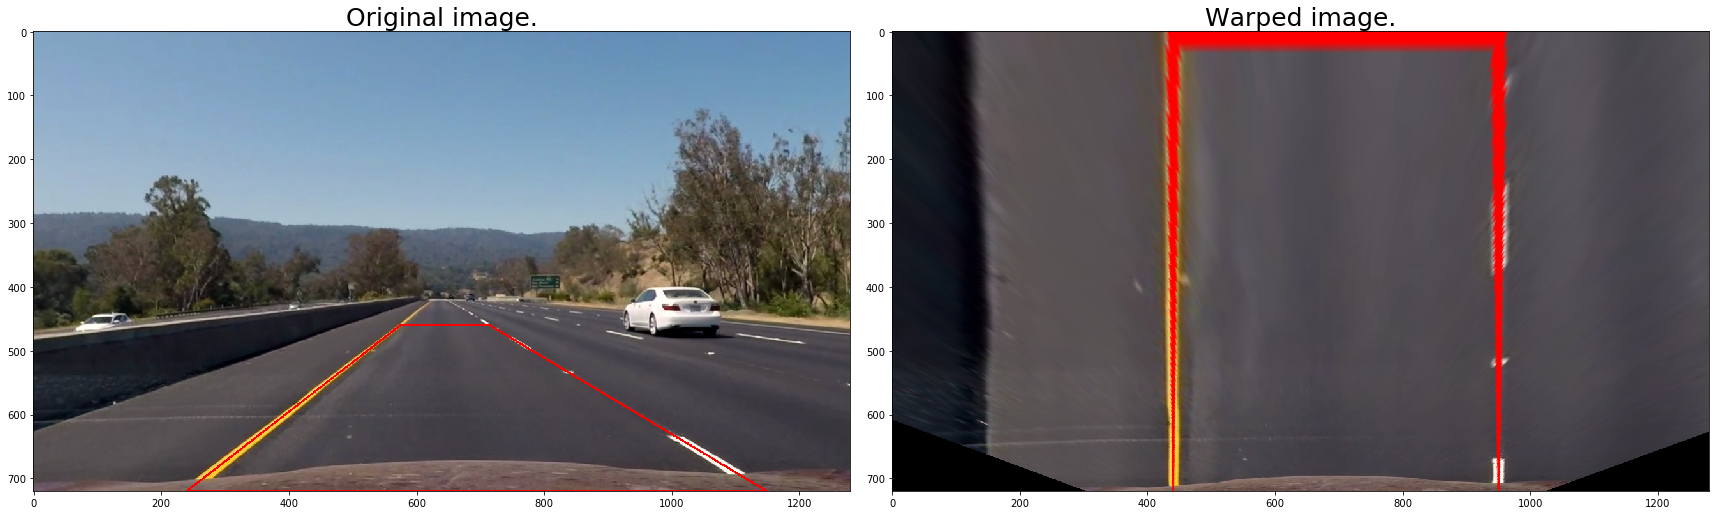

In [4]:
# Determine perspective transform.
fname = 'perspective/perspective.json'
src_points = lane.load_points(fname, 'src', dtype=np.float32)
dst_points = lane.load_points(fname, 'dst', dtype=np.float32)
perp_scaling = lane.load_points(fname, 'scaling', dtype=np.float32)
mtx_perp, mtx_perp_inv = lane.perspective_transform(src_points, dst_points)
print('Source points:\n', src_points)
print('Destination points:\n', dst_points)
print('Perspective scaling:', perp_scaling)

# Test the perspective transform.
fname = 'perspective/perspective.jpg'
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
lane.test_perspective(img, src_points, mtx_perp)

## Main pipeline

The computation of the lanes is divided in several steps:
* computing masks containing the lanes, using Grayscale and HSL color images;
* fitting two lanes using masks information: we use for that purpose the well-known RANSAC regression, adapted to this setting.

In [5]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
# print(filenames)

TEST on image: test_images/test (17).jpg (720, 1280, 3)


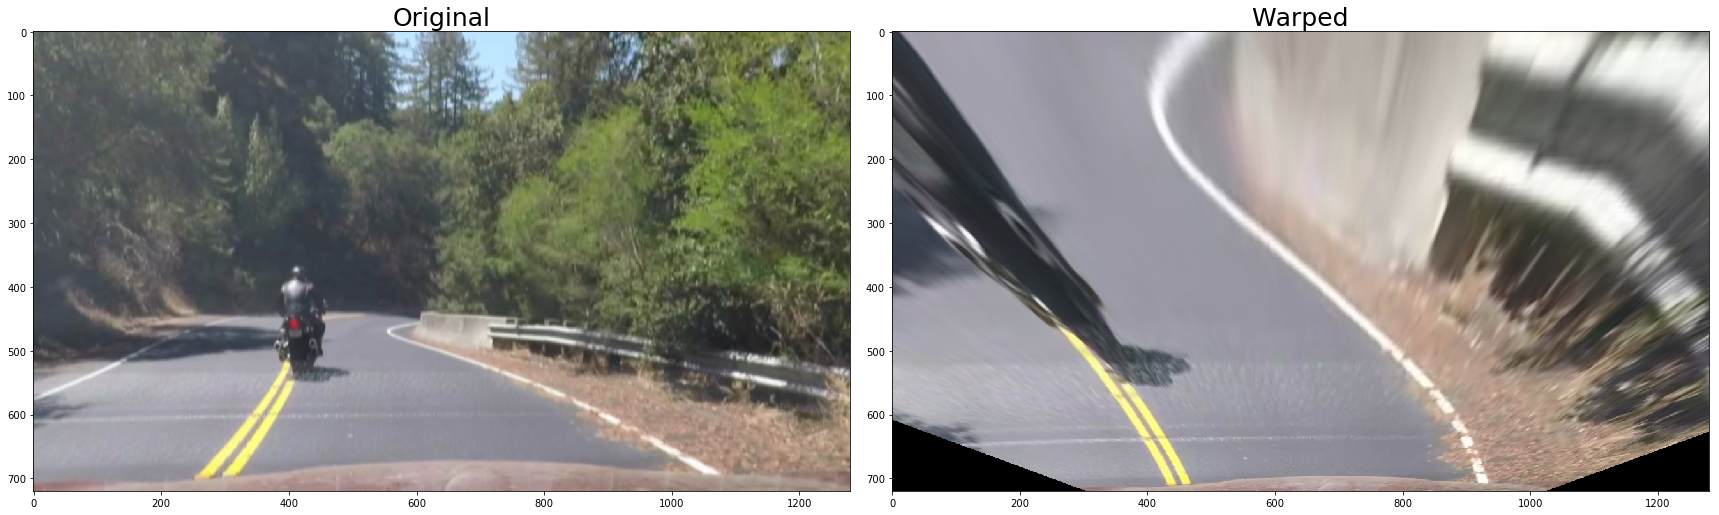

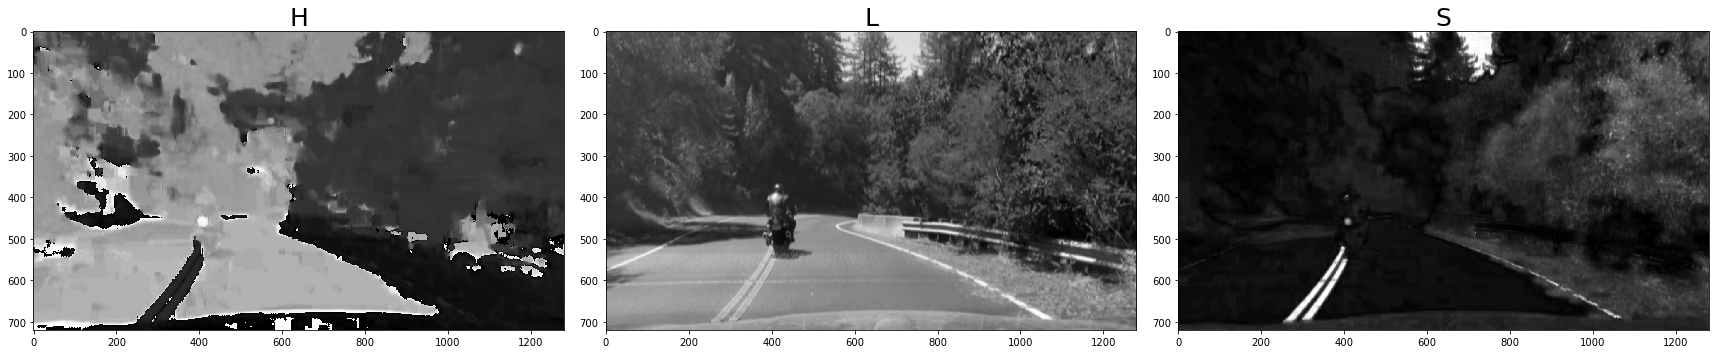

In [6]:
# Test on some image...
fname = path + os.listdir(path)[20]
img = lane.undistort_image(lane.load_image(fname), mtx, dist)
# img = adjust_gamma(img, gamma=1.)
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
print('TEST on image:', fname, img.shape)
img = cv2.GaussianBlur(img, (1, 11), 0)

# Color spaces...
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Plot the bouzin!
lane.plot_images((img, wimg), ('Original', 'Warped'), figsize=(24, 9))
lane.plot_images((img_hsl[:, : , 0], img_hsl[:, : , 1], img_hsl[:, : , 2]), ('H', 'L', 'S'), figsize=(24, 9))

### Masks from Grayscale and HSL images

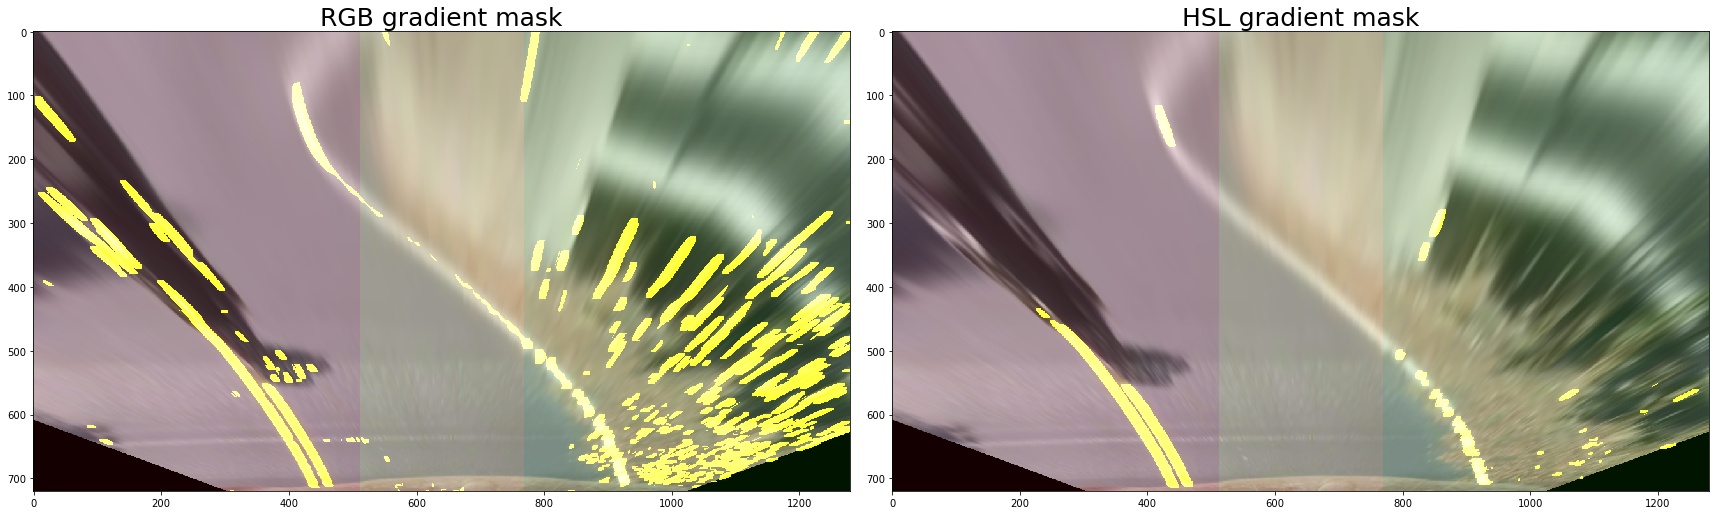

In [7]:
# Compute warped masks...
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = lane.warped_masks_original(img, mtx_perp, thresholds=[20, 20])
lmask, rmask = lane.default_left_right_masks(img, margin=0.1)

# Masks to plot...
wimgs = []
titles = ['RGB gradient mask', 'HSL gradient mask']
for i, wm in enumerate(wmasks):
    mimg = lane.draw_mask(wimg, lmask, alpha=.9, beta=1., gamma=0., color=[20, 0, 0])
    mimg = lane.draw_mask(mimg, rmask, alpha=1, beta=1., gamma=0., color=[0, 20, 0])
    mimg = lane.draw_mask(mimg, wm, alpha=1, beta=1., gamma=0., color=[255, 255, 0])
    wimgs.append(mimg)

for i in range(len(wimgs) // 2):
    lane.plot_images(wimgs[2*i:2*i+2], titles[2*i:2*i+2], figsize=(24, 9))

### RANSAC regression using the former masks

In [8]:
FLOAT_DTYPES = np.float32

# Warped image and masks
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = lane.warped_masks_original(img, mtx_perp)
lmask, rmask = lane.default_left_right_masks(img, margin=0.1)

# Masks points.
X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

# Model validation bounds.
left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
left_right_bounds[0, 0, 0] = 0.25
left_right_bounds[0, 0, 1] = 0.5
left_right_bounds[0, 1, 1] = 0.1
left_right_bounds[0, 2, 1] = 0.1
valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

# Fit regression.
l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
# l2_scales=None
res_threshold = 0.01
n_prefits = 5000
max_trials = 500000
lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                     n_prefits=n_prefits,
                                     max_trials=max_trials,
                                     l2_scales=l2_scales)
lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)

SLanesRANSACRegressor(dtype=None,
           is_valid_bounds_left=array([], shape=(0, 3, 2), dtype=float32),
           is_valid_bounds_right=array([], shape=(0, 3, 2), dtype=float32),
           l2_scales=array([ 0.005,  0.005], dtype=float32),
           max_trials=500000, n_prefits=5000, random_state=None,
           residual_threshold=0.01,
           score_lambdas=array([ 1.,  1.,  1.,  1.], dtype=float32),
           smoothing=1.0, stop_n_inliers=inf, stop_probability=0.99,
           stop_score=inf,
           w_refs_left=array([], shape=(0, 3), dtype=float32),
           w_refs_right=array([], shape=(0, 3), dtype=float32))

###  Display lanes on perspective images

In [9]:
X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
x_lane = X_lane[:, 1]

X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=False, normalise=False)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=False, normalise=False)
x1 = X1[:, 1]
x2 = X2[:, 1]
lane_wmask = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)

# Inlier / Outlier masks
inlier_mask1 = lanes_ransac.inlier_mask1_
outlier_mask1 = np.logical_not(inlier_mask1)
inlier_mask2 = lanes_ransac.inlier_mask2_
outlier_mask2 = np.logical_not(inlier_mask2)


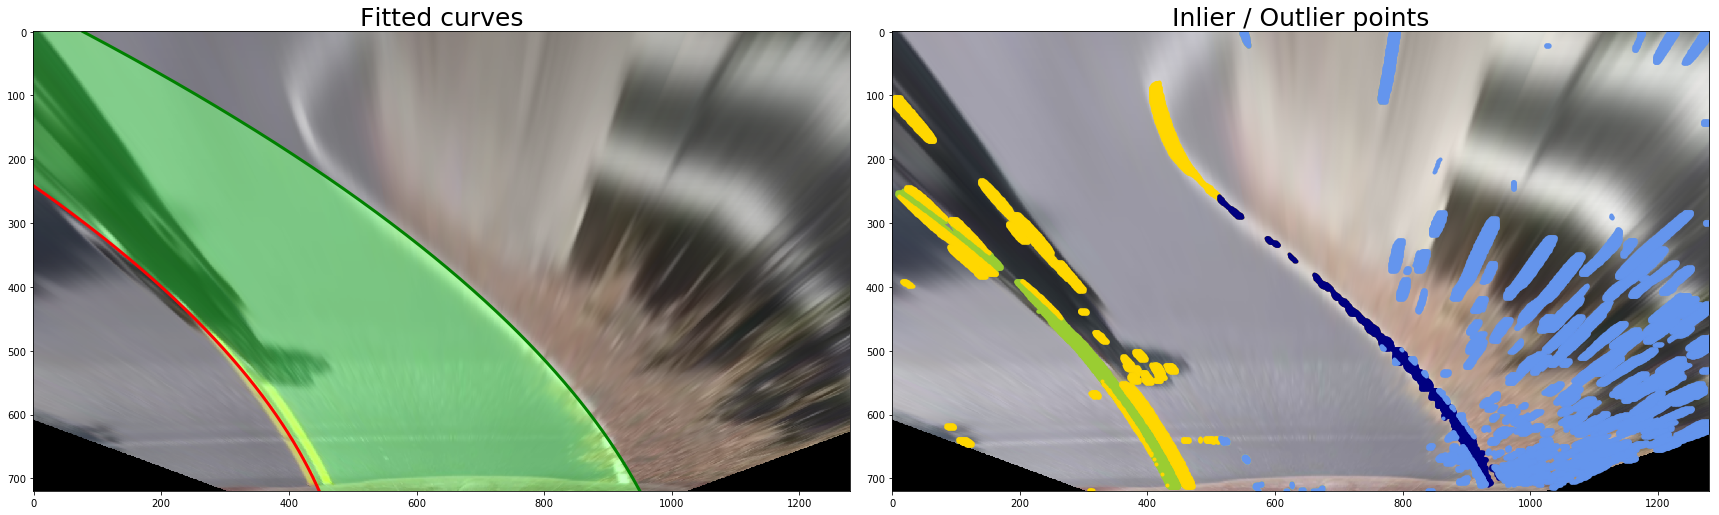

In [10]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(y1_lane, x_lane,  color='red', linestyle='-', linewidth=3)
ax1.plot(y2_lane, x_lane,  color='green', linestyle='-', linewidth=3)
wm_img = cv2.addWeighted(wimg, 0.8, lane_wmask, 0.3, 0.)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y1[inlier_mask1], x1[inlier_mask1], color='yellowgreen', marker='.')
plt.scatter(y1[outlier_mask1], x1[outlier_mask1], color='gold', marker='.')
plt.scatter(y2[inlier_mask2], x2[inlier_mask2], color='navy', marker='.')
plt.scatter(y2[outlier_mask2], x2[outlier_mask2], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

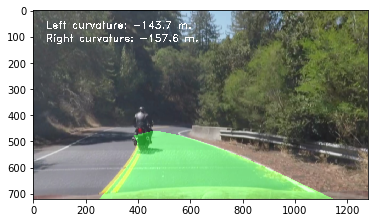

In [11]:
# Unwarp everything!
mask_lane = lane.warp_image(lane_wmask, mtx_perp_inv, flags=cv2.INTER_NEAREST)
mask_img = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

# Add curvature information.
dist_lanes = lanes_ransac.w2_[0] - lanes_ransac.w1_[0]
curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))

cv2.putText(mask_img, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
cv2.putText(mask_img, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

plt.imshow(mask_img)

### Debug frame: display all necessary information on the pipeline

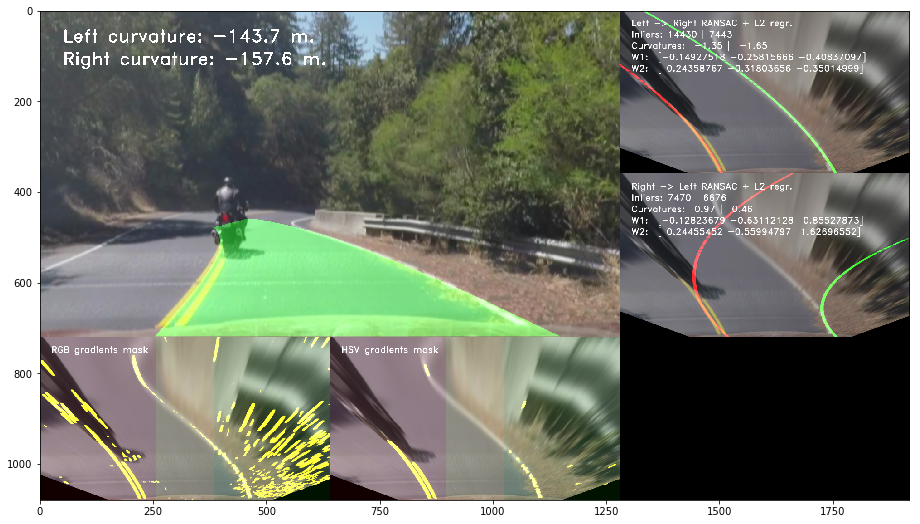

In [12]:
dimg = lane.debug_frame(mask_img, wimg, wmasks, lmask, rmask, lanes_ransac)

f, ax = plt.subplots(1, 1, figsize=(24, 9))
plt.imshow(dimg)

In [13]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

## Process individual images

The pipeline used is equivalent to the example above.

In [13]:
def process_image(path, fname, debug=True):
    path_save = 'debug/'
    img_name = fname[:-4]
    img = lane.load_image(path + fname)
    img = lane.undistort_image(img, mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = lane.warped_masks(img, mtx_perp, thresholds=[25, 30])
    lmask, rmask = lane.default_left_right_masks(img, margin=0.1)
 
    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True, dtype=np.float64)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True, dtype=np.float64)
    
    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.25
    left_right_bounds[0, 0, 1] = 0.5
    left_right_bounds[0, 1, 1] = 0.2
    left_right_bounds[0, 2, 1] = 0.1
    valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

    # Fit regression.
    res_threshold = 0.01
    l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
    score_lambdas = np.array([10., 1., 1., 1.], dtype=X1.dtype)
    n_prefits = 5000
    max_trials = 500000
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits,
                                         max_trials=max_trials,
                                         l2_scales=l2_scales,
                                         score_lambdas=score_lambdas)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    wimg_lane = cv2.addWeighted(wimg, 0.9, wmask_lane, 0.4, 0.)
    
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

    # Add curvature and position information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    position = -(lanes_ransac.w1_[0] + lanes_ransac.w2_[0]) / 2. * img.shape[1] * perp_scaling[1]
    
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    if debug:
        img_lane = lane.debug_frame(img_lane, wimg, wmasks, lmask, rmask, lanes_ransac)
    
    # Save images.
#     mpimg.imsave(path_save+img_name+'_wlane.jpg', wimg_lane)
    mpimg.imsave(path_save+img_name+'_lane.jpg', img_lane)

In [15]:
# Full pipeline on test images.
path = 'test_images/'
filenames = os.listdir(path)
for fname in filenames:
    print('Processing image: ', fname)
    process_image(path, fname)

Processing image:  test (19).jpg
Processing image:  test (6).jpg
Processing image:  test (11).jpg
Processing image:  test5.jpg
Processing image:  test (4).jpg
Processing image:  test3.jpg
Processing image:  test (16).jpg
Processing image:  test (5).jpg
Processing image:  test (8).jpg
Processing image:  test (14).jpg
Processing image:  test2.jpg
Processing image:  signs_vehicles_xygrad.jpg
Processing image:  test (10).jpg
Processing image:  test (3).jpg
Processing image:  test (7).jpg
Processing image:  test (18).jpg
Processing image:  test (13).jpg
Processing image:  test (12).jpg
Processing image:  test6.jpg
Processing image:  test (9).jpg
Processing image:  test (17).jpg
Processing image:  test1.jpg
Processing image:  test12.jpg
Processing image:  test (15).jpg
Processing image:  test (1).jpg
Processing image:  test (2).jpg
Processing image:  test4.jpg


## Process video frames

The pipeline is very similar to the previous image pipeline. The only modification is the use of previous frames to help lanes fitting.

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_frame(img_orig, debug=False):
    lanes_past = process_frame.lanes_past
    
    img = lane.undistort_image(img_orig, mtx, dist)
    wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    # Warped image and masks
    wmasks = lane.warped_masks(img, mtx_perp, thresholds=[20, 25])
    
    # Masks...
    if len(lanes_past) > 0:
        delta = 0.1
        lmask, rmask = lanes_past[-1].masks(delta)
    else:
        lmask, rmask = lane.default_left_right_masks(img, margin=0.1)
    
    # Masks points.
    X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)
    X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)

    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.25
    left_right_bounds[0, 0, 1] = 0.5
    left_right_bounds[0, 1, 1] = 0.25
    left_right_bounds[0, 2, 1] = 0.15
    
    # Left and right validation bounds.
    w_refs_left = None
    w_refs_right = None
    is_valid_bounds_left = None
    is_valid_bounds_right = None
    if len(lanes_past) > 0:
        lanes = lanes_past[-1]
        w_refs_left = np.copy(lanes.w_left).reshape((1, 3))
        w_refs_right = np.copy(lanes.w_right).reshape((1, 3))
        
        is_valid_bounds_left = np.zeros((1, 3, 2), dtype=X1.dtype)
        is_valid_bounds_left[0, 0, 1] = 1.
        is_valid_bounds_left[0, 1, 1] = 1.
        is_valid_bounds_left[0, 2, 1] = 1.
        is_valid_bounds_right = np.copy(is_valid_bounds_left)

    # Fit regression.
    res_threshold = 0.01
    l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
    score_lambdas = np.array([10., 1., 1., 1.], dtype=X1.dtype)
    smoothing = 0.3
    n_prefits = 5000
    max_trials = 500000
    if len(lanes_past) < 1:
        n_prefits *= 10
        max_trials *= 10
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits, max_trials=max_trials,
                                         l2_scales=l2_scales, smoothing=smoothing,
                                         score_lambdas=score_lambdas,
                                         w_refs_left=w_refs_left, is_valid_bounds_left=is_valid_bounds_left,
                                         w_refs_right=w_refs_right, is_valid_bounds_right=is_valid_bounds_right)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Save lanes fit.
    lanes_fit = lane.LanesFit()
    lanes_fit.init_from_regressor(lanes_ransac)
    lanes_fit.shape = wimg.shape
    lanes_fit.scaling = wimg.shape
    
    if len(lanes_past) > 10:
        lanes_past.pop(0)
    lanes_past.append(lanes_fit)
    process_frame.lanes_past = lanes_past
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = lane.predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lane.lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    # Unwarp everything!
    mask_lane = lane.warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    # Add curvature information.
    curv_left = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane.lane_curvature(lane.rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    position = -(lanes_ransac.w1_[0] + lanes_ransac.w2_[0]) // 2. * img.shape[1] * perp_scaling[1]
    
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    if debug:
        img_lane = lane.debug_frame(img_lane, wimg, wmasks, lmask, rmask, lanes_ransac)
    return img_lane
    
    
def process_frame_fake(img_orig):
    return img_orig

In [19]:
process_frame.lanes_past = []

white_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4



 12%|█▏        | 152/1261 [02:22<17:11,  1.08it/s]


 24%|██▍       | 303/1261 [04:42<15:07,  1.06it/s]


 36%|███▌      | 454/1261 [08:45<21:58,  1.63s/it]


 48%|████▊     | 605/1261 [13:11<18:40,  1.71s/it]


 60%|█████▉    | 756/1261 [15:30<08:02,  1.05it/s]


 72%|███████▏  | 907/1261 [17:58<06:41,  1.14s/it]


 84%|████████▍ | 1057/1261 [20:53<03:35,  1.06s/it]


 96%|█████████▌| 1205/1261 [23:32<00:54,  1.03it/s]


100%|█████████▉| 1260/1261 [24:50<00:01,  1.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

CPU times: user 1h 26min 22s, sys: 1min 22s, total: 1h 27min 44s
Wall time: 24min 51s


In [ ]:
process_frame.lanes_past = []

white_output = 'challenge_video_lane.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_frame) 
%time white_clip.write_videofile(white_output, audio=False)

In [20]:
process_frame.lanes_past = []

white_output = 'harder_challenge_video_lane.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_lane.mp4
[MoviePy] Writing video harder_challenge_video_lane.mp4



 13%|█▎        | 152/1200 [03:50<17:47,  1.02s/it]


 25%|██▌       | 303/1200 [09:22<34:25,  2.30s/it]


 38%|███▊      | 454/1200 [12:51<14:10,  1.14s/it]


 50%|█████     | 605/1200 [16:36<20:32,  2.07s/it]


 63%|██████▎   | 756/1200 [20:47<08:08,  1.10s/it]


 76%|███████▌  | 907/1200 [25:14<10:00,  2.05s/it]


 88%|████████▊ | 1057/1200 [30:12<05:14,  2.20s/it]


100%|█████████▉| 1199/1200 [33:58<00:01,  1.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_lane.mp4 

CPU times: user 1h 49min 29s, sys: 1min 32s, total: 1h 51min 1s
Wall time: 33min 59s


## Test the video pipeline on individual frames 

In [105]:
# Load video
process_frame.lanes_past = []
path_debug = 'debug_frames/'
cap = cv2.VideoCapture("challenge_video.mp4") 
cap = cv2.VideoCapture("harder_challenge_video.mp4")

# Specify range of frames to view
frame_start = 180
frame_end = 300
for fn in range(frame_start, frame_end):
    cap.set(1, fn)
    print('Frame %i...' % fn)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process frame.
    frame_lane = process_frame(frame, debug=True)

    # Save processed frame.
    mpimg.imsave(path_debug + 'frame_%i.jpg' % fn, frame_lane)

    # Show frames.
#     frame_lane = cv2.cvtColor(frame_lane, cv2.COLOR_RGB2BGR)
#     cv2.putText(frame_lane, "Frame "+str(fn), (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
#     cv2.imshow('window_name', frame_lane) # show frame on window
#     cv2.waitKey(1)

Frame 180...
Frame 181...
Frame 182...
Frame 183...
Frame 184...
Frame 185...
Frame 186...
Frame 187...
Frame 188...
Frame 189...
Frame 190...
Frame 191...
Frame 192...
Frame 193...
Frame 194...
Frame 195...
Frame 196...
Frame 197...
Frame 198...
Frame 199...
Frame 200...
Frame 201...
Frame 202...
Frame 203...
Frame 204...
Frame 205...
Frame 206...
Frame 207...
Frame 208...
Frame 209...
Frame 210...
Frame 211...
Frame 212...
Frame 213...
Frame 214...
Frame 215...
Frame 216...
Frame 217...
Frame 218...
Frame 219...
Frame 220...
Frame 221...
Frame 222...
Frame 223...
Frame 224...
Frame 225...
Frame 226...
Frame 227...
Frame 228...
Frame 229...
Frame 230...
Frame 231...
Frame 232...
Frame 233...
Frame 234...
Frame 235...
Frame 236...
Frame 237...
Frame 238...
Frame 239...
Frame 240...
Frame 241...
Frame 242...
Frame 243...
Frame 244...
Frame 245...
Frame 246...
Frame 247...
Frame 248...
Frame 249...
Frame 250...
Frame 251...
Frame 252...
Frame 253...
Frame 254...
Frame 255...
Frame 256...